<a href="https://colab.research.google.com/github/maruseppe/Aspect-Based-Sentiment-Analysis-using-Bart/blob/main/zero_shot_bart_mnli_topics_dataset_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dataset

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pip install datasets
from datasets import load_dataset 

In [ ]:
yahoo_dataset = load_dataset('csv', data_files='/content/gdrive/MyDrive/yahoo_answers_csv/test.csv')

## Visualize raw data via pandas and rename features

In [ ]:
yahoo_sample=yahoo_dataset["train"]
yahoo_sample.set_format("pandas")
yahoo_sample[:3]

,9,What makes friendship click?,How does the spark keep going?,"good communication is what does it. Can you move beyond small talk and say what's really on your mind. If you start doing this, my expereince is that potentially good friends will respond or shun you. Then you know who the really good friends are."
0,2,Why does Zebras have stripes?,What is the purpose or those stripes? Who do t...,this provides camouflage - predator vision is ...
1,4,What did the itsy bitsy sipder climb up?,None,waterspout
2,4,What is the difference between a Bachelors and...,None,One difference between a Bachelors and a Maste...


Columns are missing the title. It would be better to rename them to something more interpretable.
The titles can be found in the readme file of the dataset folder.

In [ ]:

colon_titles = ["class index","question title", "question content", "best answer"]

for i in range(len(colon_titles)) :
  yahoo_dataset = yahoo_dataset.rename_column(
      original_column_name=yahoo_dataset["train"].column_names[i], new_column_name=colon_titles[i]
  )
yahoo_dataset

In [ ]:
columns = yahoo_dataset["train"].column_names
columns_to_keep = ["class index","question title","best answer"]
columns_to_remove = set(columns_to_keep).symmetric_difference(columns)
yahoo_dataset = yahoo_dataset.remove_columns(columns_to_remove)
yahoo_dataset

In [ ]:
yahoo_sample1=yahoo_dataset["train"]
yahoo_sample1.set_format("pandas")
yahoo_sample1[:3]

,class index,question title,best answer
0,2,Why does Zebras have stripes?,this provides camouflage - predator vision is ...
1,4,What did the itsy bitsy sipder climb up?,waterspout
2,4,What is the difference between a Bachelors and...,One difference between a Bachelors and a Maste...


# Pre-tokenization

For tokenization, filter out None examples

In [ ]:
yahoo_dataset = yahoo_dataset.filter(lambda x: x["best answer"] is not None)

  0%|          | 0/60 [00:00<?, ?ba/s]

A good practice when doing any sort of data analysis is to grab a small random sample to get a quick feel for the type of data you’re working with. 

For better performance we concatenate quetion and answer fields that will become the hypothesis of our NLI inference

We also define a dataset variable of the true labels that will be used for metrics calculation and during plotting

In [ ]:
#yahoo_sample = yahoo_dataset["train"].shuffle(seed=42).select(range(1000))["best answer"]
yahoo_sample = yahoo_dataset["train"].shuffle(seed=42).select(range(1000))["question title"] +  yahoo_dataset["train"].shuffle(seed=42).select(range(1000))["best answer"]

yahoo_sample_labels= yahoo_dataset["train"].shuffle(seed=42).select(range(1000))["class index"]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/csv/default-5018489fd3a78b9e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-9ed6d8fa1f4279d0.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/csv/default-5018489fd3a78b9e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-9ed6d8fa1f4279d0.arrow


In [ ]:
yahoo_sample=list(yahoo_sample)
len(yahoo_sample)

In [ ]:
yahoo_sample_labels=list(yahoo_sample_labels)
len(yahoo_sample_labels)

In [ ]:
yahoo_sample_labels = [str(i) for i in yahoo_sample_labels]
len(yahoo_sample_labels)

Check that the dataset is balanced and reduce the size of each class subset

In [ ]:
yahoo_sample_1_labels_index =[index for index, value in enumerate(yahoo_sample_labels) if value == "4" and yahoo_sample_labels[:index].count("4")<100 ]
len(yahoo_sample_1_labels_index)

96

In [ ]:
yahoo_sample_4_labels =[yahoo_sample_labels[i] for i, value in enumerate(yahoo_sample_labels) if value == "1" or value == "2" or value == "3" or value == "4"  ]
len(yahoo_sample_4_labels)

404

In [ ]:
yahoo_sample_4_labels_index =[index for index, value in enumerate(yahoo_sample_labels) if value == "1" or value == "2"  or value == "3" or value == "4"  ]
len(yahoo_sample_4_labels_index)

404

In [ ]:
yahoo_sample=[ yahoo_sample[i] for i in yahoo_sample_4_labels_index]
len(yahoo_sample)

404

## Define candidate labels

In [ ]:
candidate_labels = load_dataset('text', data_files='/content/gdrive/MyDrive/yahoo_answers_csv/classes.txt')
candidate_labels = candidate_labels["train"][:4]
candidate_labels

In [ ]:
candidate_labels1=load_dataset('text', data_files='/content/gdrive/MyDrive/yahoo_answers_csv/classes.txt')
candidate_sample1=candidate_labels1["train"]
candidate_sample1.set_format("pandas")
candidate_sample1[:]

Using custom data configuration default-7ea18acd3d2cdbfb
Reusing dataset text (/root/.cache/huggingface/datasets/text/default-7ea18acd3d2cdbfb/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)


  0%|          | 0/1 [00:00<?, ?it/s]

,text
0,Society & Culture
1,Science & Mathematics
2,Health
3,Education & Reference
4,Computers & Internet
5,Sports
6,Business & Finance
7,Entertainment & Music
8,Family & Relationships
9,Politics & Government


In [ ]:
candidate_labels=list(candidate_labels["text"])

In [ ]:
import re
# Remove anything that's not alphanumeric or underscore
candidate_labels = [re.sub(r'[^\w]', ' ', sent) for sent in candidate_labels]
candidate_labels=[re.sub("   ", " ", sent) for sent in candidate_labels]

candidate_labels


['Society Culture', 'Science Mathematics', 'Health', 'Education Reference']

# Upload zero-shot pipeline 

In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

#Topics Dataset with topics inference 

## Classifier

In [ ]:
classifier_scores = []
classifier_labels = []
classifier_sequences = []
#for i, sequence in enumerate(yahoo_sample_two_labels[:10]) :
for i, sequence in enumerate(yahoo_sample[:400]) :
  classifier_dict=classifier(sequence, candidate_labels, multi_label=True)
  classifier_labels.append( classifier_dict['labels'])
  classifier_scores.append( classifier_dict['scores'])
  classifier_sequences.append( classifier_dict['sequence'])
  print(i)

In [ ]:
predictions = classifier_labels
scores = classifier_scores

## Metrics F1 score 

Let's convert class index to class label in order to be comparable with predictions

In [ ]:
# Create data frame from list
import pandas as pd
df = pd.DataFrame(yahoo_sample_4_labels)
df.columns = ['labels']
d = dict(zip([str(x) for x in range(1,5)], candidate_labels))
labels= df['labels'].map(d)
labels=list(labels)


For the sake of metrics, select only the most probable predictions

In [ ]:
predictions1 = [line[0]  for line in predictions]
predictions1

Binarize the list of multi-classes predictinos and labels with a bin number of size 4, as for are the number of possible classes

In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
#Fit label binarizer
lb.fit(candidate_labels)
lb.classes_

In [ ]:
predictions_binary=lb.transform(predictions1)
predictions_binary

In [ ]:
labels_binary=lb.transform(labels[:400])
labels_binary

Calculate F1 core with the function : 

sklearn.metrics.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

In [ ]:
from sklearn.metrics import f1_score
f1_score(labels_binary, predictions_binary, average='weighted')

0.40132536714814004

## Plot scores
 



Remember that when plotting we need to choose examples that belong to either of the four possible case studies:

True Positives : labels[i] , predictions[i][0]

False Positives : /labels[i]/ , predictions[i][0]

True Negatives : /labels[i]/ , /predictions[i][0]/

False Negatives : labels[i] , /predictions[i][0]/

Now if we decide to plot only the examples that are both in labels[i] , and in predictions[i][0] we are basically taking care of recall and precision respectively, and so, the histogram will be comparable to the F1 score

In [ ]:
import numpy as np

scores = [np.array(scores[i]).astype(float) for i in range(len(scores))]
scores = np.array(scores)


In [ ]:
# True Positives cases : labels[i] , predictions[i][0]
def scores_correspondingTo_expected_label(label) : 
  x =[]
  for i,exp_label in enumerate(labels [:400]) :
    if exp_label==label and predictions[i][0] == label :
          x.append(scores[i,0])
  return x

Text(0.5, 0, 'Multi-classes')

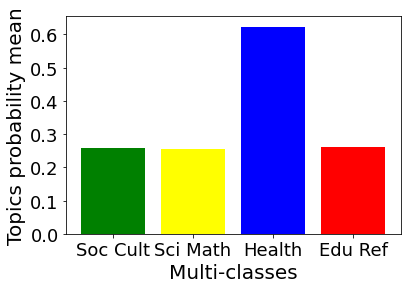

In [ ]:
import numpy as np

# society culture scores
import matplotlib.pyplot as plt

classes_scores=[]
candidate_labels=['Society Culture', 'Science Mathematics', 'Health', 'Education Reference']
for i,label in enumerate(candidate_labels) :
  classes_scores.append(np.mean(scores_correspondingTo_expected_label(label)))


# create a dataset
height = classes_scores
bars = ('Soc Cult', 'Sci Math', 'Health', 'Edu Ref')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, height, color=['green','yellow', 'blue', 'red'])

# Create names on the x-axis
plt.xticks(x_pos, bars, Fontsize=18)
plt.yticks(Fontsize=18)
plt.ylabel('Topics probability mean', Fontsize=20)
plt.xlabel('Multi-classes', Fontsize=20)


# Topics Dataset with emotions and topics inference all in parallel (not True labels case)

In [ ]:
candidate_labels=['Society Culture', 'Science Mathematics', 'Health', 'Education Reference','Joy', 'Love', 'Sadness', 'Anger']


## Classifier

In [ ]:
classifier_scores = []
classifier_labels = []
classifier_sequences = []
#for i, sequence in enumerate(yahoo_sample_two_labels[:10]) :
for i, sequence in enumerate(yahoo_sample[:400]) :
  classifier_dict=classifier(sequence, candidate_labels, multi_label=True)
  classifier_labels.append( classifier_dict['labels'])
  classifier_scores.append( classifier_dict['scores'])
  classifier_sequences.append( classifier_dict['sequence'])
  print(i)

In [ ]:
predictions = classifier_labels
scores = classifier_scores

## Plot scores

In [ ]:
import numpy as np

scores = [np.array(scores[i]).astype(float) for i in range(len(scores))]
scores = np.array(scores)


### Histogram

In [ ]:
def scores_given_label(label,predictions) : 
  x =[]
  for i in range(len(predictions)) :
    for j,prediction in enumerate(predictions[i]) :
      if label == prediction :
        x.append(scores[i,j])
  return x

Text(0.5, 0, 'Multi-classes')

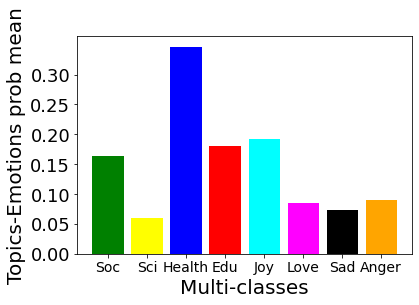

In [ ]:
import numpy as np

# society culture scores
import matplotlib.pyplot as plt

classes_scores=[]

for i,label in enumerate(candidate_labels) :
  classes_scores.append(np.mean(scores_given_label(label,predictions)))


# create a dataset
height = classes_scores
bars = ('Soc', 'Sci', 'Health', 'Edu','Joy','Love', 'Sad', 'Anger')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, height, color=['green','yellow', 'blue', 'red','cyan','magenta','black', 'orange'])


# Create names on the x-axis
plt.yticks(np.arange(0,max(height),0.05))
plt.xticks(x_pos, bars, Fontsize=14)
plt.yticks(Fontsize=18)
plt.ylabel('Topics-Emotions prob mean', Fontsize=20)
plt.xlabel('Multi-classes', Fontsize=20)